<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#source code from git repo Autoencoder_Embedding_Expert_Caracteristion_ of marota
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_x_conso(data_conso_df, dict_colnames_conso):

    # Get one hot encoding of calendar informations (hour, day, month)
    timeserie = data_conso_df.ds
    weekday = timeserie.dt.weekday
    month = timeserie.dt.month
    hour = timeserie.dt.hour
    minute = timeserie.dt.minute

    calendar_ds = pd.DataFrame({'month': month, 'weekday': weekday, 'hour': hour, 'minute': minute, 'ds': timeserie})

    # One hot encoding
    encoded_weekday = pd.get_dummies(calendar_ds['weekday'], prefix="weekday")
    encoded_month = pd.get_dummies(calendar_ds['month'], prefix="month")
    encoded_hour = pd.get_dummies(calendar_ds['hour'], prefix="hour")
    encoded_minute = pd.get_dummies(calendar_ds['minute'], prefix="minute")

    # Check time_step
    timedelta = (timeserie[1] - timeserie[0]).seconds / (60 * 15)
    nb_columns_encoded_minute = encoded_minute.shape[1]

    expected_dim = {4: 1, 2: 2, 1: 4}
    assert expected_dim[nb_columns_encoded_minute] == timedelta

    if nb_columns_encoded_minute == 1:
        calendar_encoded_ds = pd.concat([encoded_weekday, encoded_month, encoded_hour, timeserie], axis=1)
    else:
        calendar_encoded_ds = pd.concat([encoded_weekday, encoded_month, encoded_hour, encoded_minute, timeserie],
                                        axis=1)

    dict_colnames_conso['calendar'] = [el for el in calendar_encoded_ds.columns if el != 'ds']

    # Merge conso and meteo
    x_conso = pd.merge(data_conso_df, calendar_encoded_ds, on='ds', how='left')
    x_conso = x_conso.drop('type_tempo', axis=1)

    return x_conso, dict_colnames_conso


def select_variables(x_conso, dict_colnames_conso, list_variable):
    assert set(list_variable).issubset(set(dict_colnames_conso.keys()))

    mask = ['ds']
    for variable in list_variable:
        mask_variable = [el for el in x_conso.columns if el.startswith(tuple(dict_colnames_conso[variable]))]
        mask += mask_variable

    sorted_mask = [el for el in x_conso if el in mask]

    x_conso_selected_variables = x_conso[sorted_mask].copy()

    return x_conso_selected_variables


def get_x_conso_autoencoder(data_conso_df, dict_colnames_conso):

    x_conso, dict_colnames_conso = get_x_conso(data_conso_df, dict_colnames_conso)

    list_variables = ['conso', 'meteo','holiday_days']
    x_conso = select_variables(x_conso, dict_colnames_conso, list_variables)

    # Keep only average temperature
    x_conso = x_conso.drop([el for el in x_conso.columns if 'Th+0' in el[:8]], axis=1)

    return x_conso


def get_train_test_x_conso(x_conso, date_test_start, date_test_end):
    """
    split the data set in train and test set

    :param x_conso: dataframe
    :param y_conso: dataframe
    :param date_test_start: timestamp of the first day of the test set
    :param date_test_end: timestamp of the last day of the test set
    :return: dataset: dictionary containing the train and test set (x and y)
             dict_ds: dictionary containing the time series of the train and test set
    """

    mask_test = (x_conso.ds >= date_test_start) & (x_conso.ds < date_test_end + datetime.timedelta(days=1))

    x_test = x_conso[mask_test]
    x_train = x_conso[np.invert(mask_test)]

    x_test = x_test.reset_index(drop=True)
    x_train = x_train.reset_index(drop=True)

    dict_ds = {'train': x_train.ds, 'test': x_test.ds}

    dict_xconso = {}
    dict_xconso['train'] = x_train
    dict_xconso['test'] = x_test

    return dict_xconso


def normalize_xconso(dict_xconso, type_scaler = 'standard', meteo_elements=None):
    """
    Normalization of the needed columns

    :param x_conso:
    :param dict_colnames_conso:
    :return: dataset_scaled
    """
    x_test = None

    if type(dict_xconso) == dict:
        x_train = dict_xconso['train']
        if 'test' in dict_xconso.keys():
            x_test = dict_xconso['test']
    else:
        x_train = dict_xconso

    dict_xconso_scaled = {}
    
    # Getting columns to normalized
    x_train.columns
    mask_conso = [el for el in x_train.columns if el.startswith('consumption')]
    print(mask_conso)
    if meteo_elements is not None:
        mask_meteo = []
        for meteo_el in meteo_elements:
            mask_meteo += [el for el in x_train.columns if el.startswith(meteo_el)]

    # Fitting scaler on train
    if type_scaler == 'standard':
        scaler_x = StandardScaler(with_mean=True, with_std=True)
        scaler_other = StandardScaler(with_mean=True, with_std=True)
    elif type_scaler == 'minmax':
        scaler_x = MinMaxScaler()
        scaler_other = MinMaxScaler()

    scaler_x.fit(x_train[mask_conso])
    if meteo_elements is not None:
        scaler_other.fit(x_train[mask_meteo])


    # Applying filter on train
    if meteo_elements is not None:
        cols_normalized = scaler_other.transform(x_train[mask_meteo])

    x_train_scaled = x_train.copy()
    x_train_scaled[mask_conso] = scaler_x.transform(x_train[mask_conso])
    if meteo_elements is not None:
        for i, col_name in enumerate(mask_meteo):
            x_train_scaled[col_name] = cols_normalized[:, i]

    dict_xconso_scaled['train'] = x_train_scaled

    if x_test is not None:
    # Applying filter on test
        if meteo_elements is not None:
            cols_normalized = scaler_other.transform(x_test[mask_meteo])

        x_test_scaled = x_test.copy()
        x_test_scaled[mask_conso] = scaler_x.transform(x_test[mask_conso])
        if meteo_elements is not None:
            for i, col_name in enumerate(mask_meteo):
                x_test_scaled[col_name] = cols_normalized[:, i]

        dict_xconso_scaled['test'] = x_test_scaled

    return dict_xconso_scaled, scaler_x


def get_x_cond_autoencoder(x_conso, type_x = ['conso'], list_cond = ['month', 'weekday'], data_conso_df = None,slidingWindowSize=0):

    ### X
    x_ds = x_conso.copy()
    columns_ds = x_ds.columns
    conso_idx = np.argmax(['consumption' in c for c in x_ds.columns])
    temp_idx = np.argmax(['temperature' in c for c in x_ds.columns])
    
    # Enumerate days
    x_ds['day'] = (x_ds['ds'] - x_ds['ds'][0]).apply(lambda td: td.days)
    x_ds['minute'] = x_ds['ds'].dt.hour * 60 + x_ds['ds'].dt.minute

    nb_day = len(x_ds['ds'].dt.normalize().unique())

    x_ae = np.zeros((nb_day, 0))
    if not (slidingWindowSize == 0):
        x_ae = np.zeros((x_conso.shape[0] - slidingWindowSize, 0))

    if 'conso' in type_x:
        # pandas pivot
        if (slidingWindowSize==0):
            x = x_ds[[columns_ds[conso_idx], 'day', 'minute']].pivot('day', 'minute')[columns_ds[conso_idx]]
        else:
            x = x_ds[[columns_ds[conso_idx]]]
            for i in range(1, slidingWindowSize):
                x['consumption_France_shift_' + str(i)] = x[columns_ds[conso_idx]].shift(i)
            x = x.loc[slidingWindowSize:]
            x = x.reset_index(drop=True)

        # Replacing missing values due to the change of hour in march
        # TODO: interpolation for the hour of the given days
        x[x.isna()] = x.values.mean(axis=0)[7]

        # Converting to np.array
        x = x.values

        x_ae = np.concatenate((x_ae, x), axis=1)

    if 'temperature' in type_x:
        # pandas pivot
        if (slidingWindowSize == 0):
            x = x_ds[[columns_ds[temp_idx], 'day', 'minute']].pivot('day', 'minute')[columns_ds[temp_idx]]
        else:
            x = x_ds[[columns_ds[temp_idx]]]
            for i in range(1, slidingWindowSize):
                x['temperature_France_shift_' + str(i)] = x[columns_ds[temp_idx]].shift(i)
            x = x.loc[slidingWindowSize:]
            x = x.reset_index(drop=True)
        # Replacing missing values due to the change of hour in march
        # TODO: interpolation for the hour of the given days
        x[x.isna()] = x.values.mean(axis=0)[7]

        # Converting to np.array
        x = x.values

        x_ae = np.concatenate((x_ae, x), axis=1)

    # Getting corresponding date of each row
    if (slidingWindowSize == 0):
        dates = np.unique(x_conso['ds'].dt.date)
        idx_date =[np.where(x_conso['ds'].dt.date==dates[k])[0][0] for k in range(dates.shape[0])]
        ds = x_conso['ds'].iloc[idx_date]
        
        ds = ds.reset_index(drop=True)
    else:
        ds = x_conso['ds']
        ds = ds.loc[slidingWindowSize:]
        ds = ds.reset_index(drop=True)

    ### Cond
    if list_cond is not None:
        cond, cond_dims = get_cond_autoencoder(x_conso, ds, list_cond, data_conso_df)
        assert x_ae.shape[0] == cond.shape[0]
    else:
        cond = np.zeros((x_ae.shape[0],1), dtype=int)
        cond_dims = [1]

    return x_ae, cond, ds, cond_dims


def get_cond_autoencoder(x_conso, ds, list_cond=['month', 'weekday'], data_conso_df=None):

    # get calendar info
    calendar_info = pd.DataFrame(ds)
    calendar_info['month'] = calendar_info.ds.dt.month
    calendar_info['weekday'] = calendar_info.ds.dt.weekday
    calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x: int(x))
    
    # get conditional variables

    list_one_hot = list()
    columns_x = x_conso.columns
    conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
    temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
    
    for type_cond in list_cond:
        if 'month' in type_cond:
            # month
            one_hot_month = pd.get_dummies(calendar_info.month, prefix='month')
            list_one_hot.append(np.asarray(one_hot_month))

        elif type_cond == 'weekday': #on considere ici les jours travaillés
            list_one_hot.append(np.asarray(calendar_info.is_weekday).reshape(-1,1))

        elif type_cond == 'day' :#on considere ici weekday
            one_hot_weekday = pd.get_dummies(calendar_info.weekday, prefix='weekday')
            list_one_hot.append(np.asarray(one_hot_weekday))
            
        elif 'holiday' in type_cond:#on considere ici is-weekday
            # weekday
            #one_hot_weekday = pd.get_dummies(calendar_info.is_weekday, prefix='weekday')
            #list_one_hot.append(one_hot_weekday)
            holidays_df= x_conso[['ds', 'is_holiday_day']].copy()
            holidays_df['day'] = holidays_df['ds'].dt.date
            daily_holidays__df = pd.DataFrame(holidays_df.groupby(['day']).max())
            list_one_hot.append(np.asarray(daily_holidays__df.is_holiday_day).reshape(-1,1))
                                           
        # Continious variable representing the avarage temperature of the day
            # TODO change as well the counting of days as above
        elif type_cond == 'av_temp':
            meteo_nat_df = x_conso[['ds', columns_x[temp_idx]]].copy()
            #day_count = (meteo_nat_df['ds'] - meteo_nat_df['ds'][0]).apply(lambda td: td.days)
            #meteo_nat_df['day'] = day_count
            dates = meteo_nat_df['ds'].dt.date
            meteo_nat_df['day'] = dates

            mean_meteo_nat_df = pd.DataFrame(meteo_nat_df.groupby(['day']).mean())

            scaler = MinMaxScaler()
            scalerfit = scaler.fit(np.array(mean_meteo_nat_df[columns_x[temp_idx]]).reshape(-1, 1))
            cond_temp = scalerfit.transform(np.array(mean_meteo_nat_df[columns_x[temp_idx]]).reshape(-1, 1))

            list_one_hot.append(np.asarray(cond_temp))

        # Full temperature profile
        elif 'temperature' in type_cond:
            x_ds = x_conso.copy()

            # Enumerate days
            x_ds['day'] = (x_ds['ds'] - x_ds['ds'][0]).apply(lambda td: td.days)
            x_ds['minute'] = x_ds['ds'].dt.hour * 60 + x_ds['ds'].dt.minute

            # pandas pivot
            cond_temp = x_ds[[columns_x[temp_idx], 'day', 'minute']].pivot('day', 'minute')[columns_x[temp_idx]]

            # Replacing missing values due to the change of hour in march
            # TODO: interpolation for the hour of the given days
            cond_temp[cond_temp.isna()] = cond_temp.values.mean(axis=0)[7]

            list_one_hot.append(np.asarray(cond_temp))
            
        elif 'humidity' in type_cond:
            x_ds = x_conso.copy()

            # Enumerate days
            x_ds['day'] = (x_ds['ds'] - x_ds['ds'][0]).apply(lambda td: td.days)
            x_ds['minute'] = x_ds['ds'].dt.hour * 60 + x_ds['ds'].dt.minute

            # pandas pivot
            cond_hum = x_ds[['humidity', 'day', 'minute']].pivot('day', 'minute')['humidity']

            # Replacing missing values due to the change of hour in march
            # TODO: interpolation for the hour of the given days
            cond_hum[cond_hum.isna()] = cond_hum.values.mean(axis=0)[7]

            list_one_hot.append(np.asarray(cond_hum))
            
        elif 'windspeed' in type_cond:
            x_ds = x_conso.copy()

            # Enumerate days
            x_ds['day'] = (x_ds['ds'] - x_ds['ds'][0]).apply(lambda td: td.days)
            x_ds['minute'] = x_ds['ds'].dt.hour * 60 + x_ds['ds'].dt.minute

            # pandas pivot
            cond_wind = x_ds[['windspeed', 'day', 'minute']].pivot('day', 'minute')['windspeed']

            # Replacing missing values due to the change of hour in march
            # TODO: interpolation for the hour of the given days
            cond_wind[cond_wind.isna()] = cond_wind.values.mean(axis=0)[7]

            list_one_hot.append(np.asarray(cond_wind))

        else:
            x_ds = x_conso.copy()

            # Enumerate days
            x_ds['day'] = (x_ds['ds'] - x_ds['ds'][0]).apply(lambda td: td.days)
            x_ds['minute'] = x_ds['ds'].dt.hour * 60 + x_ds['ds'].dt.minute

            # pandas pivot
            if len(np.unique(x_ds[type_cond].values)) < 20:
                cond_cd = x_conso[['ds', type_cond]].copy()
                cond_cd['day'] = cond_cd['ds'].dt.date
                cond_cd__df = pd.DataFrame(cond_cd.groupby(['day']).max())
                list_one_hot.append(np.asarray(pd.get_dummies(cond_cd__df[type_cond], prefix=type_cond)))

            else:
                cond_cd = x_ds[[type_cond, 'day', 'minute']].pivot('day', 'minute')[type_cond]

            # Replacing missing values due to the change of hour in march
            # TODO: interpolation for the hour of the given days
                cond_cd.bfill(inplace=True)

                list_one_hot.append(np.asarray(cond_cd).reshape(-1,1))   

    # get conditional matrix
    [print(list_cond[i],z.shape) for i,z in enumerate(list_one_hot)]
    cond_dims = [z.shape[1] for z in list_one_hot]
    cond = np.concatenate(list_one_hot, axis=1)

    return cond, cond_dims

def get_y_autoencoder(x_conso,slidingWindowSize=0):



    ### X
    y_ds = x_conso.copy()
    slidingWindowSize=0
    columns_x = x_conso.columns
    conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])

    # Enumerate days and identify the time
    y_ds['day'] = (y_ds['ds'] - y_ds['ds'][0]).apply(lambda td: td.days)
    y_ds['minute'] = y_ds['ds'].dt.hour * 60 + y_ds['ds'].dt.minute

    nb_day = len(y_ds['ds'].dt.normalize().unique())

    y_ae = np.zeros((nb_day, 0))
    if not (slidingWindowSize == 0):
        y_ae = np.zeros((x_conso.shape[0] - slidingWindowSize, 0))

    # pandas pivot
    if (slidingWindowSize==0):
        y = y_ds[[columns_x[conso_idx], 'day', 'minute']].pivot('day', 'minute')[columns_x[conso_idx]]
    else:
        y = y_ds[[columns_x[conso_idx]]]
        for i in range(1, slidingWindowSize):
            x['consumption_France_t0_shift_' + str(i)] = x[columns_x[conso_idx]].shift(i)
        y = y.loc[slidingWindowSize:]
        y = y.reset_index(drop=True)

    # Replacing missing values due to the change of hour in march
    # TODO: interpolation for the hour of the given days
    y[y.isna()] = y.values.mean(axis=0)[7]

    # Converting to np.array
    y = y.values

    y_ae = np.concatenate((y_ae, y), axis=1)
        
    return y_ae
    

def get_dataset_autoencoder(dict_xconso, type_x=['conso'],list_cond=None,slidingWindowSize=0, isYNormalized=True,dict_xconso_unormalized=None, embedding=False):

    dataset = {}
    
    
    for key, x_conso_normalized in dict_xconso.items():

        x, cond, cvae_ds, cond_dims = get_x_cond_autoencoder(x_conso=x_conso_normalized, type_x=type_x, list_cond=list_cond,slidingWindowSize=slidingWindowSize)
        train_x = [x, cond]

        if embedding==True:
            cond_lim = np.cumsum([0]+cond_dims)
            print(len(cond_lim))
            cond_to_emb = [cond[:, cond_lim[i]:cond_lim[i+1]] for i in range(len(cond_lim)-1)]
            train_x = [x] + cond_to_emb

        if(isYNormalized):
            dataset[key] = {'x': train_x, 'y': x, 'ds': cvae_ds}
        else:
            x_conso_non_normalized=dict_xconso_unormalized[key]
            y =  get_y_autoencoder(x_conso_non_normalized,slidingWindowSize=0)
            dataset[key] = {'x': train_x, 'y': y, 'ds': cvae_ds}

    if embedding==False:
        return dataset
    else:
        return dataset, cond_dims

Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [3]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2017.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#Visualize data frame head
x_conso.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day,conso_final,day_ahead
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0,56739.0,53500.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0,56233.0,53000.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0,57239.0,54700.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0,60642.0,57300.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0,60479.0,57300.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [4]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [5]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [6]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year


In [7]:
calendar_info

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [8]:
#importation des données météo
meteo1_csv = os.path.join('data', "meteo_events.csv")
meteo2_csv = os.path.join('data', "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [9]:
meteo_records.describe()

,snow,floods,storm,hurricane,heavy_rains,cold,hot
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,0.092350,0.077049,0.087432,0.068852,0.087432,0.074863,0.157377
std,0.289598,0.266742,0.282544,0.253272,0.282544,0.263243,0.364255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [11]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [12]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [13]:
meteo_records

,snow,floods,storm,hurricane,heavy_rains,cold,hot
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1825,0,0,0,0,0,0,0
1826,0,0,0,0,0,0,0
1827,0,0,0,0,0,0,0
1828,0,0,0,0,0,0,0


# Tools to evaluate the representations

In [14]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(2, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(2, 3, 2)
    plt.bar(np.arange(z_dim)+1,np.log(6)*model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(2, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();
    
    plt.subplot(2, 3, 5)
    plt.bar(np.arange(z_dim)+1,1-model_eval['modularity'])
    plt.xlabel('latent variables')
    plt.title('Modularity score : %.2f'%np.mean(1-model_eval['modularity']));

In [15]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [16]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [17]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

In [35]:
#root git folder 
name_model="vae_test"
path_second_folder = %pwd #"/home/goubetcle/Documents/Git/VAE/"
save_path = os.path.join(path_second_folder,"Results")#"/home/goubetcle/Documents/VAE/"
log_dir_model=os.path.join(save_path,"logs")
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [26]:
import importlib

sys.path.append(path_second_folder+'/src')

#import models, loss_class, params_class,AE_blocks,metrics
from src.models import *
#importlib.reload(models)
from src.loss_class import *
#importlib.reload(loss_class)
from src.params_class import *
#importlib.reload(params_class)
import src.AE_blocks
#importlib.reload(AE_blocks)
from src.metrics import *
#importlib.reload(metrics)


## Construire et entrainer un modèle VAE ou CVAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)
- les dimensions de notre embedding des conditions dans le cas dans CVAE

In [27]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [28]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [29]:
to_cond = ["temperature", "month"]
dataset_emb, cond_to_emb = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=to_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
3


In [37]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [38]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [39]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 3

In [40]:

def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 42,
               "test_0":1}

vae_loss = VAELoss(loss_weights = loss_weights, custom_loss=custom_loss)
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [41]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/Users/antoinemarot/dev/VAE/Results/logs/vae_test',
 'model_params': <src.params_class.ModelParams at 0x141704cf8>,
 'training_params': <src.params_class.TrainingParams at 0x141704d68>}

In [42]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 24478       x_inputs[0][0]                   
                                                                 cond_inputs_0[0][0]           

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
Train on 1647 samples, validate on 183 samples
Epoch 1/2000
1647/1647 [==============================] - 2s 1ms/sample - loss: 219.2063 - val_loss: 217.5880
Epoch 2/2000
1647/1647 [==============================] - 1s 376us/sample - loss: 158.5816 - val_loss: 160.9524
Epoch 3/2000
1647/1647 [==============================] - 1s 354us/sample - loss: 122.6665 - val_loss: 125.1812
Epoch 4/2000
1647/1647 [==============================] - 1s 409us/sample - loss: 99.8173 - val_loss: 103.9293
Epoch 5/2000
1647/1647 [==============================] - 1s 370us/sample - loss: 83.8159 - val_loss: 87.2048
Epoch 6/2000
1647/1647 [==============================] - 1s 401us/sample - loss: 72.1906 - val_loss: 73.6319
Epoch 7/2000
1647/1647 [==============================] - 1s 365us/sample - loss: 62.7961 - val_loss: 64.1693
Epoch 8/2000
1647/1647 [==============================] - 1s 367us/sample - loss: 55.9115 - val_loss: 56.8932
Epoch 9/2000
1647/1647 [=======================

1647/1647 [==============================] - 0s 300us/sample - loss: 7.0304 - val_loss: 6.3139
Epoch 75/2000
1647/1647 [==============================] - 1s 367us/sample - loss: 6.8789 - val_loss: 6.3737
Epoch 76/2000
1647/1647 [==============================] - 0s 288us/sample - loss: 6.8161 - val_loss: 6.1030
Epoch 77/2000
1647/1647 [==============================] - 1s 402us/sample - loss: 6.7620 - val_loss: 6.1321
Epoch 78/2000
1647/1647 [==============================] - 1s 305us/sample - loss: 6.6827 - val_loss: 5.9115
Epoch 79/2000
1647/1647 [==============================] - 1s 356us/sample - loss: 6.4996 - val_loss: 6.0185
Epoch 80/2000
1647/1647 [==============================] - 1s 537us/sample - loss: 6.5019 - val_loss: 5.8221
Epoch 81/2000
1647/1647 [==============================] - 1s 461us/sample - loss: 6.2781 - val_loss: 5.8670
Epoch 82/2000
1647/1647 [==============================] - 1s 566us/sample - loss: 6.2102 - val_loss: 5.6918
Epoch 83/2000
1647/1647 [========

Epoch 149/2000
1647/1647 [==============================] - 0s 301us/sample - loss: 4.0632 - val_loss: 3.9386
Epoch 150/2000
1647/1647 [==============================] - 0s 272us/sample - loss: 4.0426 - val_loss: 4.0052
Epoch 151/2000
1647/1647 [==============================] - 0s 277us/sample - loss: 4.0284 - val_loss: 3.8868
Epoch 152/2000
1647/1647 [==============================] - 0s 267us/sample - loss: 4.0658 - val_loss: 3.9347
Epoch 153/2000
1647/1647 [==============================] - 0s 258us/sample - loss: 4.0288 - val_loss: 3.8292
Epoch 154/2000
1647/1647 [==============================] - 0s 261us/sample - loss: 4.0106 - val_loss: 3.8108
Epoch 155/2000
1647/1647 [==============================] - 0s 263us/sample - loss: 4.0086 - val_loss: 3.9870
Epoch 156/2000
1647/1647 [==============================] - 0s 257us/sample - loss: 4.0052 - val_loss: 3.8483
Epoch 157/2000
1647/1647 [==============================] - 0s 260us/sample - loss: 3.9778 - val_loss: 3.8140
Epoch 158/

1647/1647 [==============================] - 0s 292us/sample - loss: 3.4863 - val_loss: 3.3774
Epoch 224/2000
1647/1647 [==============================] - 0s 288us/sample - loss: 3.4563 - val_loss: 3.3044
Epoch 225/2000
1647/1647 [==============================] - 0s 289us/sample - loss: 3.4768 - val_loss: 3.4662
Epoch 226/2000
1647/1647 [==============================] - 1s 322us/sample - loss: 3.4573 - val_loss: 3.5786
Epoch 227/2000
1647/1647 [==============================] - 1s 391us/sample - loss: 3.4327 - val_loss: 3.4069
Epoch 228/2000
1647/1647 [==============================] - 1s 359us/sample - loss: 3.4378 - val_loss: 3.4129
Epoch 229/2000
1647/1647 [==============================] - 0s 259us/sample - loss: 3.4588 - val_loss: 3.4273
Epoch 230/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 3.4606 - val_loss: 3.5382
Epoch 231/2000
1647/1647 [==============================] - 0s 273us/sample - loss: 3.4571 - val_loss: 3.4759
Epoch 232/2000
1647/1647 

1647/1647 [==============================] - 0s 271us/sample - loss: 3.1937 - val_loss: 3.1602
Epoch 298/2000
1647/1647 [==============================] - 0s 277us/sample - loss: 3.1489 - val_loss: 3.1388
Epoch 299/2000
1647/1647 [==============================] - 0s 273us/sample - loss: 3.1732 - val_loss: 3.1435
Epoch 300/2000
1647/1647 [==============================] - 0s 262us/sample - loss: 3.1707 - val_loss: 3.3832
Epoch 301/2000
1647/1647 [==============================] - 0s 264us/sample - loss: 3.1749 - val_loss: 3.2561
Epoch 302/2000
1647/1647 [==============================] - 1s 365us/sample - loss: 3.1797 - val_loss: 2.9562
Epoch 303/2000
1647/1647 [==============================] - 1s 335us/sample - loss: 3.1817 - val_loss: 3.1583
Epoch 304/2000
1647/1647 [==============================] - 0s 268us/sample - loss: 3.1442 - val_loss: 3.1857
Epoch 305/2000
1647/1647 [==============================] - 0s 293us/sample - loss: 3.1614 - val_loss: 3.1938
Epoch 306/2000
1647/1647 

1647/1647 [==============================] - 0s 271us/sample - loss: 2.9772 - val_loss: 2.9738
Epoch 372/2000
1647/1647 [==============================] - 0s 267us/sample - loss: 3.0232 - val_loss: 3.0397
Epoch 373/2000
1647/1647 [==============================] - 0s 264us/sample - loss: 2.9677 - val_loss: 2.9539
Epoch 374/2000
1647/1647 [==============================] - 0s 263us/sample - loss: 2.9256 - val_loss: 2.9657
Epoch 375/2000
1647/1647 [==============================] - 1s 361us/sample - loss: 3.0090 - val_loss: 2.9366
Epoch 376/2000
1647/1647 [==============================] - 0s 270us/sample - loss: 2.9860 - val_loss: 3.0264
Epoch 377/2000
1647/1647 [==============================] - 0s 269us/sample - loss: 2.9680 - val_loss: 2.9781
Epoch 378/2000
1647/1647 [==============================] - 0s 281us/sample - loss: 2.9803 - val_loss: 3.0254
Epoch 379/2000
1647/1647 [==============================] - 0s 267us/sample - loss: 2.9489 - val_loss: 2.9797
Epoch 380/2000
1647/1647 

1647/1647 [==============================] - 0s 274us/sample - loss: 2.8549 - val_loss: 2.9874
Epoch 446/2000
1647/1647 [==============================] - 0s 259us/sample - loss: 2.8558 - val_loss: 3.0086
Epoch 447/2000
1647/1647 [==============================] - 0s 256us/sample - loss: 2.8442 - val_loss: 2.9845
Epoch 448/2000
1647/1647 [==============================] - 0s 267us/sample - loss: 2.8786 - val_loss: 2.8662
Epoch 449/2000
1647/1647 [==============================] - 0s 287us/sample - loss: 2.8615 - val_loss: 2.8178
Epoch 450/2000
1647/1647 [==============================] - 0s 290us/sample - loss: 2.8652 - val_loss: 2.9606
Epoch 451/2000
1647/1647 [==============================] - 0s 269us/sample - loss: 2.8755 - val_loss: 2.9032
Epoch 452/2000
1647/1647 [==============================] - 0s 265us/sample - loss: 2.8255 - val_loss: 2.9898
Epoch 453/2000
1647/1647 [==============================] - 0s 264us/sample - loss: 2.8369 - val_loss: 2.8371
Epoch 454/2000
1647/1647 

1647/1647 [==============================] - 1s 314us/sample - loss: 2.7598 - val_loss: 2.8150
Epoch 520/2000
1647/1647 [==============================] - 1s 320us/sample - loss: 2.7443 - val_loss: 2.7707
Epoch 521/2000
1647/1647 [==============================] - 0s 302us/sample - loss: 2.7569 - val_loss: 2.7313
Epoch 522/2000
1647/1647 [==============================] - 1s 304us/sample - loss: 2.7679 - val_loss: 2.7891
Epoch 523/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 2.7670 - val_loss: 2.8292
Epoch 524/2000
1647/1647 [==============================] - 0s 295us/sample - loss: 2.7608 - val_loss: 2.7927
Epoch 525/2000
1647/1647 [==============================] - 1s 305us/sample - loss: 2.7491 - val_loss: 2.8259
Epoch 526/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 2.7575 - val_loss: 2.9144
Epoch 527/2000
1647/1647 [==============================] - 0s 295us/sample - loss: 2.7526 - val_loss: 2.9051
Epoch 528/2000
1647/1647 

1647/1647 [==============================] - 1s 328us/sample - loss: 2.7163 - val_loss: 2.7792
Epoch 594/2000
1647/1647 [==============================] - 1s 385us/sample - loss: 2.7030 - val_loss: 2.6982
Epoch 595/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 2.6785 - val_loss: 2.7840
Epoch 596/2000
1647/1647 [==============================] - 1s 391us/sample - loss: 2.7026 - val_loss: 2.7272
Epoch 597/2000
1647/1647 [==============================] - 0s 293us/sample - loss: 2.6582 - val_loss: 2.7659
Epoch 598/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 2.6634 - val_loss: 2.7006
Epoch 599/2000
1647/1647 [==============================] - 1s 317us/sample - loss: 2.6742 - val_loss: 2.6515
Epoch 600/2000
1647/1647 [==============================] - 1s 402us/sample - loss: 2.6928 - val_loss: 2.7589
Epoch 601/2000
1647/1647 [==============================] - 1s 376us/sample - loss: 2.6956 - val_loss: 2.6594
Epoch 602/2000
1647/1647 

1647/1647 [==============================] - 1s 306us/sample - loss: 2.6293 - val_loss: 2.7946
Epoch 668/2000
1647/1647 [==============================] - 1s 325us/sample - loss: 2.6070 - val_loss: 2.6426
Epoch 669/2000
1647/1647 [==============================] - 1s 393us/sample - loss: 2.6235 - val_loss: 2.6776
Epoch 670/2000
1647/1647 [==============================] - 1s 339us/sample - loss: 2.6023 - val_loss: 2.6582
Epoch 671/2000
1647/1647 [==============================] - 0s 302us/sample - loss: 2.6201 - val_loss: 2.7040
Epoch 672/2000
1647/1647 [==============================] - 1s 318us/sample - loss: 2.5903 - val_loss: 2.6926
Epoch 673/2000
1647/1647 [==============================] - 1s 386us/sample - loss: 2.6066 - val_loss: 2.6822
Epoch 674/2000
1647/1647 [==============================] - 1s 406us/sample - loss: 2.5979 - val_loss: 2.6106
Epoch 675/2000
1647/1647 [==============================] - 1s 322us/sample - loss: 2.5914 - val_loss: 2.6347
Epoch 676/2000
1647/1647 

1647/1647 [==============================] - 0s 302us/sample - loss: 2.5477 - val_loss: 2.6353
Epoch 742/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 2.5674 - val_loss: 2.6002
Epoch 743/2000
1647/1647 [==============================] - 0s 298us/sample - loss: 2.5381 - val_loss: 2.6356
Epoch 744/2000
1647/1647 [==============================] - 1s 463us/sample - loss: 2.5347 - val_loss: 2.6128
Epoch 745/2000
1647/1647 [==============================] - 1s 356us/sample - loss: 2.5419 - val_loss: 2.5734
Epoch 746/2000
1647/1647 [==============================] - 1s 323us/sample - loss: 2.5245 - val_loss: 2.6308
Epoch 747/2000
1647/1647 [==============================] - 1s 360us/sample - loss: 2.5191 - val_loss: 2.5839
Epoch 748/2000
1647/1647 [==============================] - 1s 321us/sample - loss: 2.5154 - val_loss: 2.5281
Epoch 749/2000
1647/1647 [==============================] - 1s 447us/sample - loss: 2.5526 - val_loss: 2.5688
Epoch 750/2000
1647/1647 

1647/1647 [==============================] - 1s 331us/sample - loss: 2.4727 - val_loss: 2.5830
Epoch 816/2000
1647/1647 [==============================] - 0s 299us/sample - loss: 2.4742 - val_loss: 2.5999
Epoch 817/2000
1647/1647 [==============================] - 0s 303us/sample - loss: 2.5039 - val_loss: 2.5934
Epoch 818/2000
1647/1647 [==============================] - 1s 346us/sample - loss: 2.4970 - val_loss: 2.5597
Epoch 819/2000
1647/1647 [==============================] - 1s 532us/sample - loss: 2.4952 - val_loss: 2.5526
Epoch 820/2000
1647/1647 [==============================] - 1s 523us/sample - loss: 2.4535 - val_loss: 2.6121
Epoch 821/2000
1647/1647 [==============================] - 1s 375us/sample - loss: 2.4875 - val_loss: 2.5131
Epoch 822/2000
1647/1647 [==============================] - 0s 253us/sample - loss: 2.4951 - val_loss: 2.6276
Epoch 823/2000
1647/1647 [==============================] - 1s 444us/sample - loss: 2.4594 - val_loss: 2.5951
Epoch 824/2000
1647/1647 

1647/1647 [==============================] - 0s 268us/sample - loss: 2.4371 - val_loss: 2.4468
Epoch 890/2000
1647/1647 [==============================] - 0s 276us/sample - loss: 2.4391 - val_loss: 2.6226
Epoch 891/2000
1647/1647 [==============================] - 1s 307us/sample - loss: 2.4285 - val_loss: 2.5175
Epoch 892/2000
1647/1647 [==============================] - 1s 356us/sample - loss: 2.4280 - val_loss: 2.5017
Epoch 893/2000
1647/1647 [==============================] - 0s 295us/sample - loss: 2.4527 - val_loss: 2.5164
Epoch 894/2000
1647/1647 [==============================] - 0s 259us/sample - loss: 2.4301 - val_loss: 2.4334
Epoch 895/2000
1647/1647 [==============================] - 0s 266us/sample - loss: 2.4259 - val_loss: 2.4966
Epoch 896/2000
1647/1647 [==============================] - 0s 281us/sample - loss: 2.4294 - val_loss: 2.4359
Epoch 897/2000
1647/1647 [==============================] - 0s 253us/sample - loss: 2.4327 - val_loss: 2.5158
Epoch 898/2000
1647/1647 

1647/1647 [==============================] - 1s 360us/sample - loss: 2.4082 - val_loss: 2.3223
Epoch 964/2000
1647/1647 [==============================] - 0s 295us/sample - loss: 2.4497 - val_loss: 2.4284
Epoch 965/2000
1647/1647 [==============================] - 0s 264us/sample - loss: 2.3912 - val_loss: 2.3638
Epoch 966/2000
1647/1647 [==============================] - 1s 305us/sample - loss: 2.3950 - val_loss: 2.3852
Epoch 967/2000
1647/1647 [==============================] - 0s 299us/sample - loss: 2.3782 - val_loss: 2.4419
Epoch 968/2000
1647/1647 [==============================] - 1s 369us/sample - loss: 2.3905 - val_loss: 2.5136
Epoch 969/2000
1647/1647 [==============================] - 0s 286us/sample - loss: 2.3771 - val_loss: 2.4862
Epoch 970/2000
1647/1647 [==============================] - 1s 307us/sample - loss: 2.3911 - val_loss: 2.4076
Epoch 971/2000
1647/1647 [==============================] - 1s 352us/sample - loss: 2.4025 - val_loss: 2.4676
Epoch 972/2000
1647/1647 

1647/1647 [==============================] - 0s 231us/sample - loss: 2.3803 - val_loss: 2.4877
Epoch 1038/2000
1647/1647 [==============================] - 0s 240us/sample - loss: 2.3618 - val_loss: 2.4314
Epoch 1039/2000
1647/1647 [==============================] - 0s 260us/sample - loss: 2.3549 - val_loss: 2.3625
Epoch 1040/2000
1647/1647 [==============================] - 0s 261us/sample - loss: 2.3467 - val_loss: 2.3991
Epoch 1041/2000
1647/1647 [==============================] - 0s 243us/sample - loss: 2.3386 - val_loss: 2.5007
Epoch 1042/2000
1647/1647 [==============================] - 0s 233us/sample - loss: 2.3610 - val_loss: 2.4618
Epoch 1043/2000
1647/1647 [==============================] - 0s 243us/sample - loss: 2.3441 - val_loss: 2.4274
Epoch 1044/2000
1647/1647 [==============================] - 0s 240us/sample - loss: 2.3691 - val_loss: 2.4314
Epoch 1045/2000
1647/1647 [==============================] - 0s 234us/sample - loss: 2.3807 - val_loss: 2.4427
Epoch 1046/2000
1

Epoch 1111/2000
1647/1647 [==============================] - 0s 274us/sample - loss: 2.3309 - val_loss: 2.4423
Epoch 1112/2000
1647/1647 [==============================] - 1s 310us/sample - loss: 2.3200 - val_loss: 2.4532
Epoch 1113/2000
1647/1647 [==============================] - 1s 370us/sample - loss: 2.3029 - val_loss: 2.4364
Epoch 1114/2000
1647/1647 [==============================] - 0s 295us/sample - loss: 2.3449 - val_loss: 2.3506
Epoch 1115/2000
1647/1647 [==============================] - 0s 294us/sample - loss: 2.3065 - val_loss: 2.4774
Epoch 1116/2000
1647/1647 [==============================] - 0s 279us/sample - loss: 2.3573 - val_loss: 2.3424
Epoch 1117/2000
1647/1647 [==============================] - 0s 258us/sample - loss: 2.3249 - val_loss: 2.4270
Epoch 1118/2000
1647/1647 [==============================] - 0s 292us/sample - loss: 2.2900 - val_loss: 2.5030
Epoch 1119/2000
1647/1647 [==============================] - 0s 300us/sample - loss: 2.3139 - val_loss: 2.3835
E

Epoch 1185/2000
1647/1647 [==============================] - 0s 258us/sample - loss: 2.2977 - val_loss: 2.3493
Epoch 1186/2000
1647/1647 [==============================] - 0s 254us/sample - loss: 2.3086 - val_loss: 2.3401
Epoch 1187/2000
1647/1647 [==============================] - 1s 308us/sample - loss: 2.3076 - val_loss: 2.4217
Epoch 1188/2000
1647/1647 [==============================] - 0s 267us/sample - loss: 2.3079 - val_loss: 2.4158
Epoch 1189/2000
1647/1647 [==============================] - 0s 296us/sample - loss: 2.2736 - val_loss: 2.3186
Epoch 1190/2000
1647/1647 [==============================] - 1s 324us/sample - loss: 2.3077 - val_loss: 2.4198
Epoch 1191/2000
1647/1647 [==============================] - 0s 271us/sample - loss: 2.2947 - val_loss: 2.3536
Epoch 1192/2000
1647/1647 [==============================] - 0s 256us/sample - loss: 2.2867 - val_loss: 2.4871
Epoch 1193/2000
1647/1647 [==============================] - 0s 257us/sample - loss: 2.3080 - val_loss: 2.3263
E

Epoch 1259/2000
1647/1647 [==============================] - 0s 266us/sample - loss: 2.2755 - val_loss: 2.3318
Epoch 1260/2000
1647/1647 [==============================] - 0s 273us/sample - loss: 2.2642 - val_loss: 2.3485
Epoch 1261/2000
1647/1647 [==============================] - 0s 295us/sample - loss: 2.2824 - val_loss: 2.4195
Epoch 1262/2000
1647/1647 [==============================] - 1s 340us/sample - loss: 2.2578 - val_loss: 2.3401
Epoch 1263/2000
1647/1647 [==============================] - 1s 319us/sample - loss: 2.2888 - val_loss: 2.3895
Epoch 1264/2000
1647/1647 [==============================] - 0s 254us/sample - loss: 2.2735 - val_loss: 2.2735
Epoch 1265/2000
1647/1647 [==============================] - 0s 302us/sample - loss: 2.2518 - val_loss: 2.2848
Epoch 1266/2000
1647/1647 [==============================] - 0s 244us/sample - loss: 2.2822 - val_loss: 2.4201
Epoch 1267/2000
1647/1647 [==============================] - 0s 246us/sample - loss: 2.2934 - val_loss: 2.3534
E

Epoch 1333/2000
1647/1647 [==============================] - 1s 345us/sample - loss: 2.2440 - val_loss: 2.2144
Epoch 1334/2000
1647/1647 [==============================] - 0s 248us/sample - loss: 2.2491 - val_loss: 2.2913
Epoch 1335/2000
1647/1647 [==============================] - 0s 264us/sample - loss: 2.2442 - val_loss: 2.4007
Epoch 1336/2000
1647/1647 [==============================] - 1s 320us/sample - loss: 2.2806 - val_loss: 2.2964
Epoch 1337/2000
1647/1647 [==============================] - 0s 242us/sample - loss: 2.2530 - val_loss: 2.4155
Epoch 1338/2000
1647/1647 [==============================] - 0s 303us/sample - loss: 2.2676 - val_loss: 2.3153
Epoch 1339/2000
1647/1647 [==============================] - 1s 397us/sample - loss: 2.2152 - val_loss: 2.3298
Epoch 1340/2000
1647/1647 [==============================] - 0s 259us/sample - loss: 2.2591 - val_loss: 2.4232
Epoch 1341/2000
1647/1647 [==============================] - 1s 337us/sample - loss: 2.2424 - val_loss: 2.3110
E

Epoch 1407/2000
1647/1647 [==============================] - 1s 418us/sample - loss: 2.2136 - val_loss: 2.4532
Epoch 1408/2000
1647/1647 [==============================] - 1s 375us/sample - loss: 2.2430 - val_loss: 2.3422
Epoch 1409/2000
1647/1647 [==============================] - 1s 392us/sample - loss: 2.2182 - val_loss: 2.3417
Epoch 1410/2000
1647/1647 [==============================] - 1s 328us/sample - loss: 2.2216 - val_loss: 2.2752
Epoch 1411/2000
1647/1647 [==============================] - 0s 276us/sample - loss: 2.2440 - val_loss: 2.3086
Epoch 1412/2000
1647/1647 [==============================] - 0s 285us/sample - loss: 2.2235 - val_loss: 2.3498
Epoch 1413/2000
1647/1647 [==============================] - 0s 278us/sample - loss: 2.2513 - val_loss: 2.2911
Epoch 1414/2000
1647/1647 [==============================] - 0s 279us/sample - loss: 2.2584 - val_loss: 2.3503
Epoch 1415/2000
1647/1647 [==============================] - 1s 368us/sample - loss: 2.2317 - val_loss: 2.3061
E

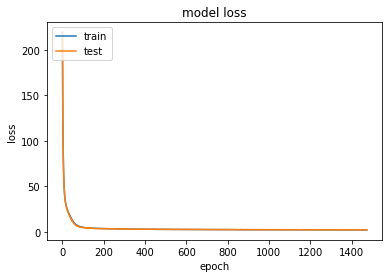

## MODEL SAVED ##


In [44]:
new_cae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 2000, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

## Evaluer l'importance et la qualité des embeggings appris

Nous allons voir:
- l'importance portée par des variables dans la représentation latente
- l'importance portée par des variables dans l'embedding conditionnel

Nous nous appuyons pour cela sur des score d'information, de démêlement, de compacité et de modularité

Nous devrions constater que des variables importante dans l'embedding conditionnel ne le sont plus dans la représentation latente: elles ont été factorisées

In [45]:
x_encoded = new_cae.encoder.predict(dataset_emb['train']['x'])[0]

Mutual Information Gap : 0.12


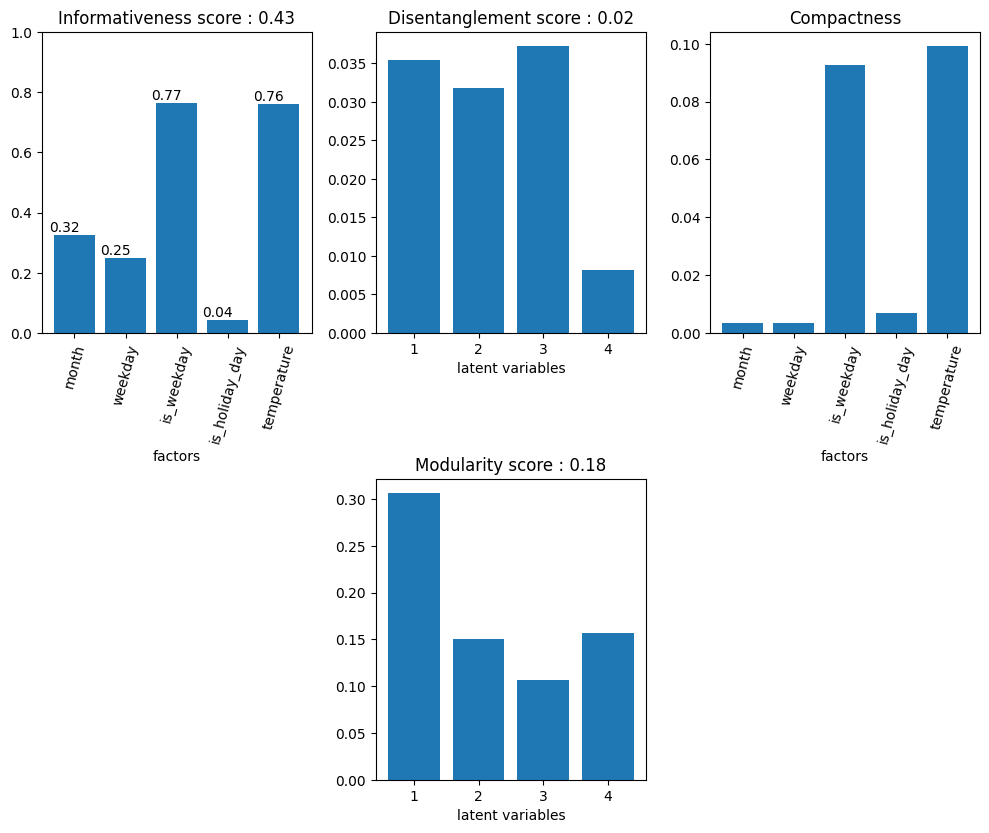

In [46]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [47]:
x_hat = new_cae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.8639465650965987

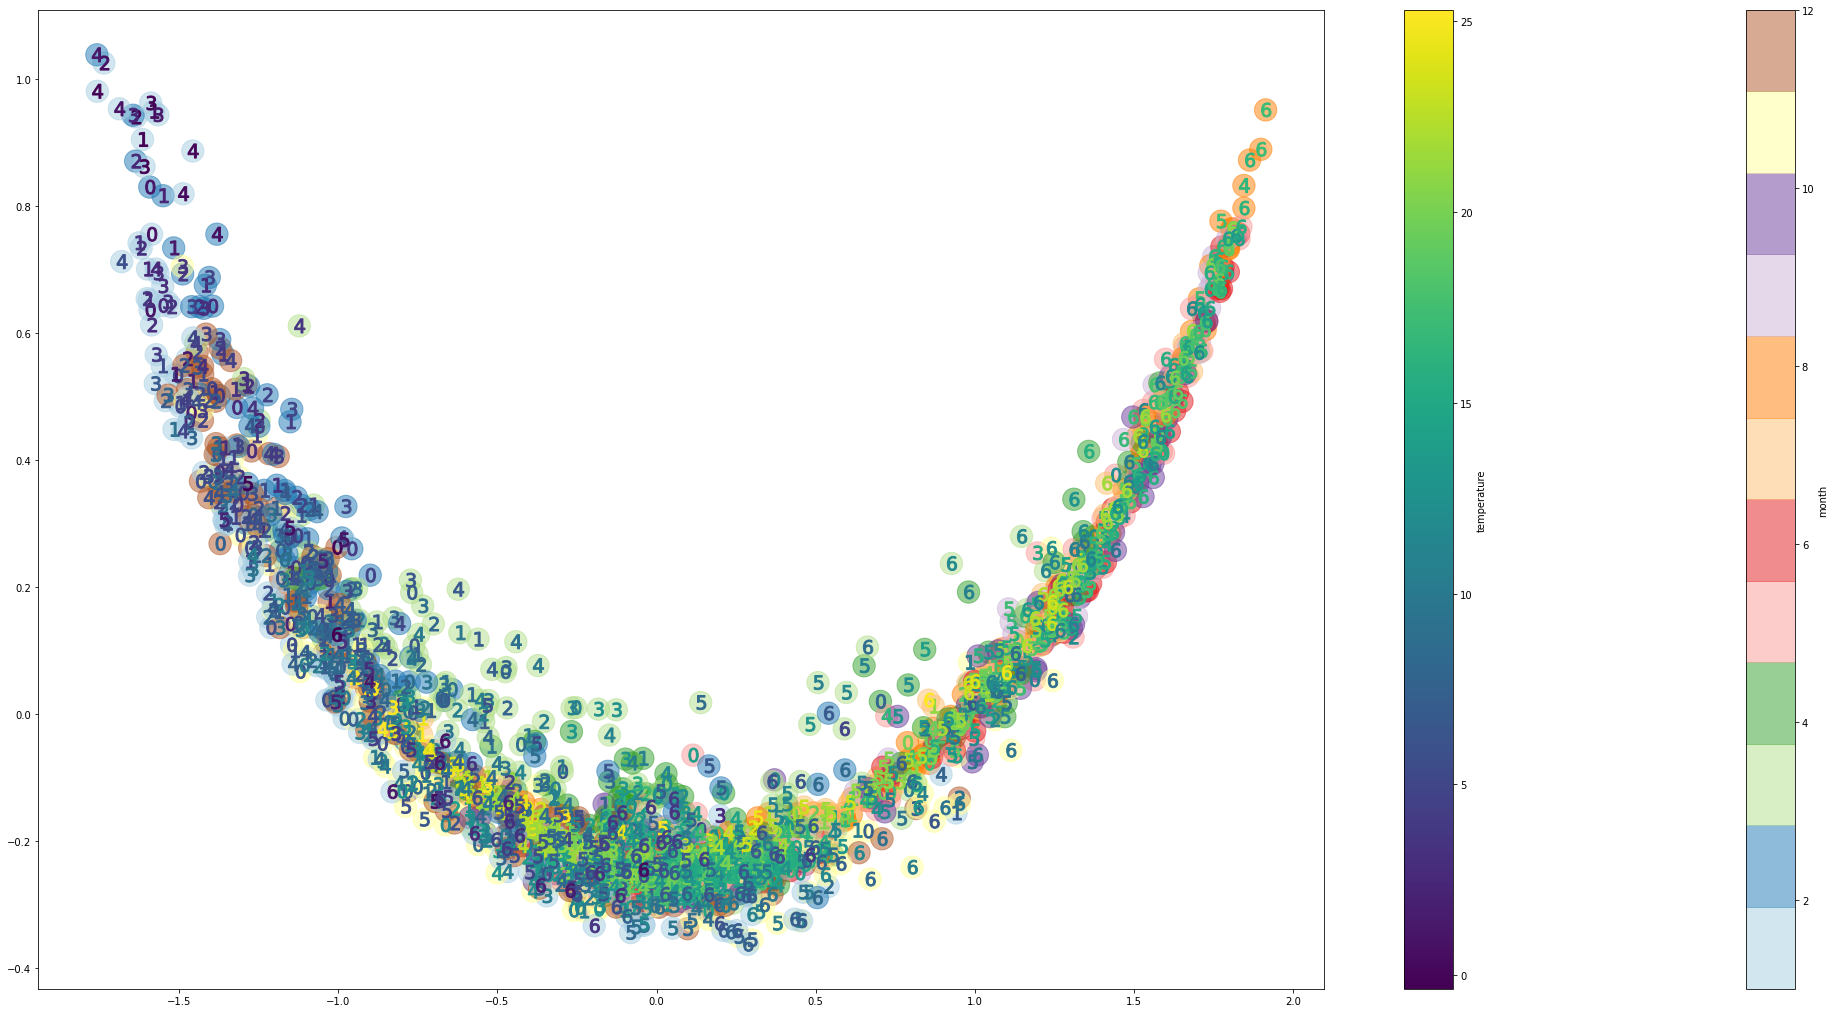

In [48]:
prez_2D(x_encoded)

Mutual Information Gap : 0.05


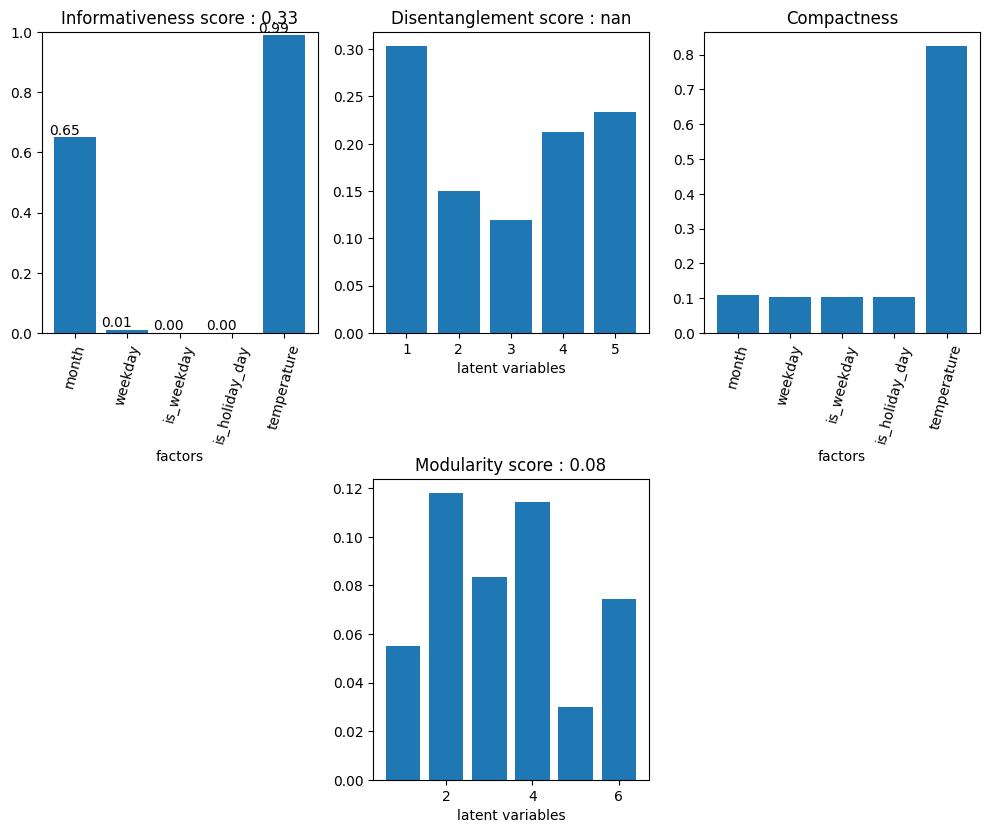

In [49]:
cond_emb = new_cae.cond_embedding.predict(dataset_emb['train']['x'][1:])
model_eval, importanceMatrix =evaluate_latent_code(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 6, factorDesc)